In [169]:
#%load_ext autoreload
%autoreload

# Statistics

This notebook contains plots and other code to explore guesses of the players of the game.

### Table of Content:

* ['Guesses' stats](#guess-stats)
* [Ground truth related stats](#ground-truth-stats)


In [170]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
%run ./prepare_data.ipynb






## <a class="anchor" id="guess-stats">Guesses stats</a>

### Most popular and least votes

In [171]:
# code from https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675
# function creating leaderboard

def create_leaderboard(df,col_name, tab_header):
    leaderboard = df[col_name].value_counts(ascending=True)
    s = pd.Series(leaderboard, name=tab_header)
    df2 = s.to_frame().sort_values(tab_header, ascending=False)
    return df2

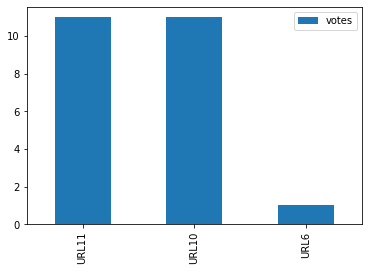

In [172]:
# total number of votes per link
votes_links = create_leaderboard(df_raw,'Current URL','votes')
votes_links.plot.bar(y='votes'); # plot histogram


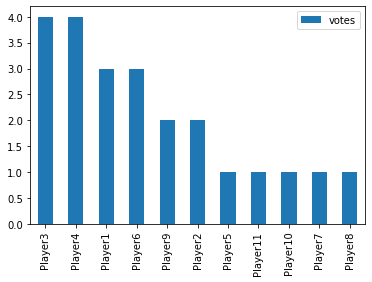

In [173]:
# total votes for each player

total_votes = create_leaderboard(df_raw,'Guess','votes')
total_votes.plot.bar(y='votes'); # plot histogram

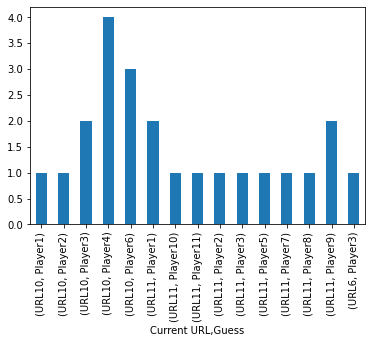

In [174]:
# stats of guesses per URL

guess_stats = df_raw.groupby(by=['Current URL', 'Guess'])['Guess'].count()
s = pd.Series(guess_stats, name="votes")
df_guess = s.to_frame().sort_values("votes", ascending=False).reset_index()
guess_stats.plot.bar(x='Current URL'); # plot histogram


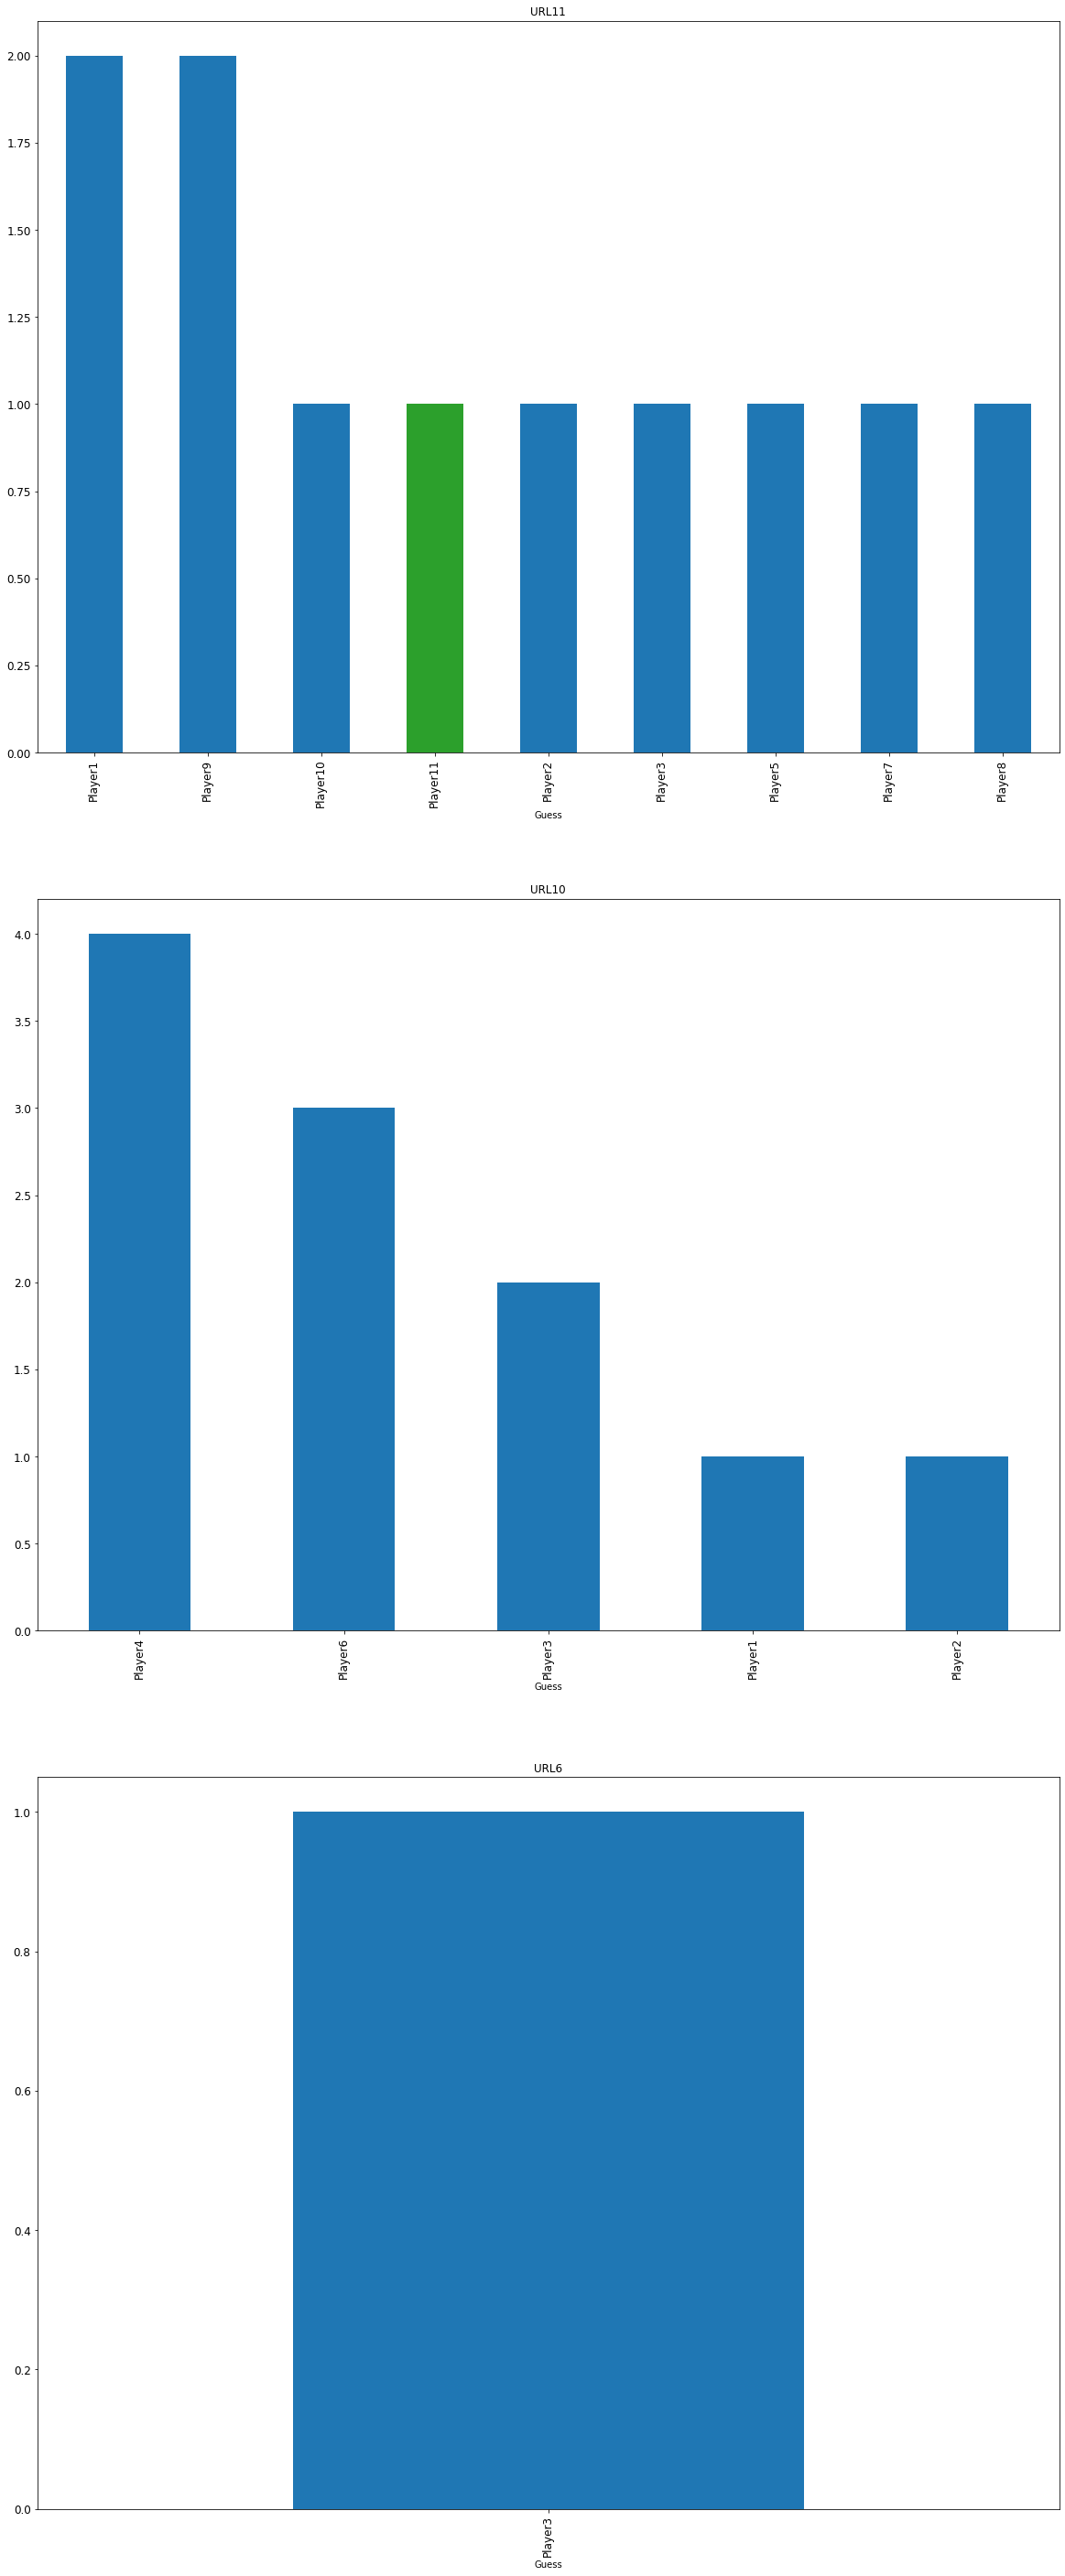

In [175]:
# bar chart per URL, the correct answer is colored in green, the rest of the guesses are blue

fig, axes = plt.subplots(len(urls),1,figsize=(20, 50)) #ncols=len(urls)#,)
for i,ax in enumerate(axes):
    url = urls[i]
    temp_df = df_guess.loc[df_guess['Current URL'] == url]
    labels = temp_df['Guess']
    cor_ans = df2_raw[df2_raw['URL'] == url]['Player'].values[0]
    ind=labels.isin([cor_ans])
    color=list(map(lambda x: 'C2' if x else 'C0', ind))
    #width = len(ind) * [1]
    temp_df.loc[:,['Guess','votes']].plot.bar(ax=ax,subplots=True, x='Guess',y='votes',color=color, fontsize=12);
    ax.get_legend().remove()
    ax.set_title(url,fontdict={'fontsize':12})
plt.show()



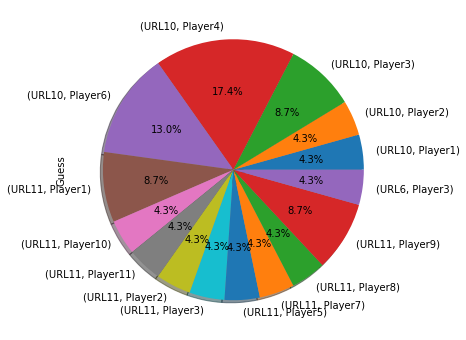

In [176]:
# combined pie chart
guess_stats.plot.pie(subplots=True,y='votes',figsize=(6, 6),autopct='%1.1f%%',shadow = True);

In [177]:
print(df_guess.columns)

Index(['Current URL', 'Guess', 'votes'], dtype='object')


In [178]:
df = df_guess.loc[df_guess['Current URL'] == 'URL6']
df.loc[:,['Guess','votes']]

,Guess,votes
14,Player3,1


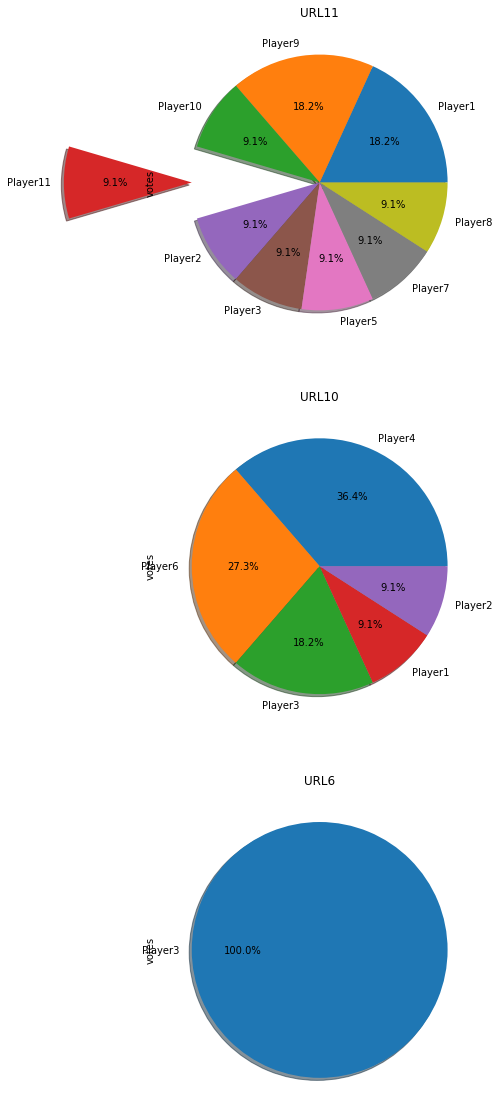

In [179]:
#FIXME: position of correct answer
fig, axes = plt.subplots(len(urls),1,figsize=(30, 20)) #ncols=len(urls)#,)
for i,ax in enumerate(axes):
    url = urls[i]
    temp_df = df_guess.loc[df_guess['Current URL'] == url]
    labels = temp_df['Guess']
    cor_ans = df2_raw[df2_raw['URL'] == url]['Player'].values[0]
    ind=labels.isin([cor_ans])
    explode=list(map(int, ind))
    temp_df.loc[:,['Guess','votes']].plot.pie(ax=ax,subplots=True,labels = labels, y='votes', autopct='%1.1f%%',shadow = True,explode=explode);
    ax.get_legend().remove()
    ax.set_title(url)
plt.show()


## <a class="anchor" id="ground-truth-stats">Ground truth related stats </a>

First, we compute the intersection between players column of ground truth df and guesses column of guess df, for all URLs.
Note that one guess is inherently incorrect (by the rules of the game).

In [180]:
print(df_raw)
print(df2_raw.head())
#intersected_df = pd.merge(df_player_guess,df2_raw, how='inner', left_on='Guess', right_on='Player')
#intersected_df = df_player_guess.where(df_player_guess.values==df2_raw.values).notna()
intersected_df = set(df_player_guess['Guess']).intersection(set(df2_raw['Player']))
intersected_df

   Current URL    Player     Guess
0        URL11   Player1   Player2
1        URL11   Player2  Player10
2        URL11   Player7   Player1
3        URL11   Player8  Player11
4        URL11   Player6   Player1
5        URL11   Player4   Player5
6        URL11   Player3   Player8
7        URL11   Player5   Player9
8        URL11  Player10   Player9
9        URL11   Player9   Player7
10       URL11  Player11   Player3
11       URL10  Player11   Player1
12       URL10   Player1   Player4
13       URL10   Player6   Player3
14       URL10   Player2   Player4
15       URL10   Player3   Player6
16       URL10   Player9   Player6
17       URL10   Player8   Player4
18       URL10   Player4   Player2
19       URL10  Player10   Player6
20       URL10   Player5   Player4
21       URL10   Player7   Player3
22        URL6  Player11   Player3
     Player    URL
0   Player1   URL1
1   Player2   URL2
2   Player3   URL3
3   Player6   URL6
4  Player10  URL10


{'Player1', 'Player10', 'Player11', 'Player2', 'Player3', 'Player6'}

In [181]:
# Correct guesses per player





In [182]:
# Best and worst guessed players
